In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('datasets/vaccination_tweets.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8082 non-null   int64 
 1   user_name         8082 non-null   object
 2   user_location     6452 non-null   object
 3   user_description  7576 non-null   object
 4   user_created      8082 non-null   object
 5   user_followers    8082 non-null   int64 
 6   user_friends      8082 non-null   int64 
 7   user_favourites   8082 non-null   int64 
 8   user_verified     8082 non-null   bool  
 9   date              8082 non-null   object
 10  text              8082 non-null   object
 11  hashtags          6133 non-null   object
 12  source            8081 non-null   object
 13  retweets          8082 non-null   int64 
 14  favorites         8082 non-null   int64 
 15  is_retweet        8082 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 899.9+ KB


In [16]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [9]:
df.drop(columns=['id'], inplace=True)
cols = df.columns[:-7]
df.rename(columns=dict(zip(cols, [col[5:] for col in cols])), inplace = True)

KeyError: "['id'] not found in axis"

In [10]:
df['verified_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

KeyError: 'verified_reviews'

In [11]:
df.columns

Index(['name', 'location', 'description', 'created', 'followers', 'friends',
       'favourites', 'verified', 'date', 'text', 'hashtags', 'source',
       'retweets', 'favorites', 'is_retweet'],
      dtype='object')

# data Preprocessing

## verified Account or not

In [7]:
df['user_verified']=df['user_verified'].apply(lambda x:'verified' if x==True else 'not_verified')

KeyError: 'user_verified'

## Account Age

In [19]:
from datetime import date
df['today']=date.today()
df['user_created']=pd.to_datetime(df['user_created']).dt.year
df['today']=pd.to_datetime(df['today'])
df['today']=df['today'].dt.year
df['acc_age']= df['today']-df['user_created']

## Days Of December

In [20]:
print(max(df['date']))
print(min(df['date']))

2021-04-21 08:35:41
2020-12-12 11:55:28


In [21]:
df['date']=pd.to_datetime(df['date'])

In [22]:
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))

<ipython-input-22-0329bedfdd8d>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))


## Total Engagement

In [23]:
df['total_engagement']=df['retweets']+df['favorites']

## Tweets length
### The tweet length can be no longer than 280 characters so let's check tweets length

In [24]:
df['text'].values[:2]

array(['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF',
       "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm"],
      dtype=object)

In [25]:
df['tweet_lenght']=df['text'].apply(lambda x:len(x))
df['tweet_lenght'].describe()

count    8082.000000
mean      129.849666
std        20.179716
min        27.000000
25%       130.000000
50%       139.000000
75%       140.000000
max       154.000000
Name: tweet_lenght, dtype: float64

# Tweet length class
### short < mean < long

In [26]:
df['tweet_length']=df['text'].apply(lambda x:'short' if len(x)<=130 else 'long')

In [12]:
df.columns

Index(['name', 'location', 'description', 'created', 'followers', 'friends',
       'favourites', 'verified', 'date', 'text', 'hashtags', 'source',
       'retweets', 'favorites', 'is_retweet', 'tweet_lenght', 'tweet_length'],
      dtype='object')

In [27]:
df['user_location'].value_counts()

London, England             124
Malaysia                    115
India                        94
London                       83
Canada                       79
                           ... 
Lethbridge, Alberta           1
In a Galaxy far far away      1
Zürich, Schweiz               1
Freiburg im Breisgau          1
Salixburg, Deutschland        1
Name: user_location, Length: 2380, dtype: int64

# Fix Country location

In [28]:
loc_df = df['user_location'].str.split(',',expand=True)
loc_df=loc_df.rename(columns={0:'first_loc',1:'second_loc'})

### fixing states with country shortcuts

In [30]:
# Remove Spaces 
loc_df['second_loc'] = loc_df['second_loc'].str.strip()
# Rename States 
state_fix = {'Ontario': 'Canada','United Arab Emirates': 'UAE','TX': 'USA','NY': 'USA'
                  ,'FL': 'USA','England': 'UK','Watford': 'UK','GA': 'USA','IL': 'USA'
                  ,'Alberta': 'Canada','WA': 'USA','NC': 'USA','British Columbia': 'Canada','MA': 'USA','ON':'Canada'
            ,'OH':'USA','MO':'USA','AZ':'USA','NJ':'USA','CA':'USA','DC':'USA','AB':'USA','PA':'USA','SC':'USA'
            ,'VA':'USA','TN':'USA','New York':'USA','Dubai':'UAE','CO':'USA'}
loc_df = loc_df.replace({"second_loc": state_fix}) 
loc_df['second_loc'].value_counts()[:20]

USA                863
UK                 540
Canada             186
India              178
Ireland             91
UAE                 77
United Kingdom      75
Germany             61
Belgium             26
France              24
South Africa        23
Scotland            22
Pakistan            19
Qatar               17
London              17
MI                  16
New South Wales     16
Deutschland         16
Malaysia            16
Australia           15
Name: second_loc, dtype: int64

## hashtags count

In [31]:
df['Hash'] = df['text'].apply(lambda word:word.count('#'))

## Mentions Count

In [32]:
df['Men'] = df['text'].apply(lambda word:word.count('@'))

In [33]:
#('https://t.co/) this part in tweets refers to photos,videos
df['med'] = df['text'].apply(lambda word:word.count('https://t.co/'))
df['med'] = df['med'].apply(lambda x:'No Media' if x==0 else 'Media')

In [34]:
df['user_followers'].value_counts()

2        52
1        44
106      41
0        38
6        36
         ..
36640     1
5927      1
1833      1
4937      1
2033      1
Name: user_followers, Length: 2991, dtype: int64

In [35]:
df['acc_class'] = df['user_followers'].apply(lambda x:'weak'if x<=100 else ('norm' if 1000>=x>100 else 
                                                                       ('strong' if 10000>=x>1000
                                                                        else 'influencer')))
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,dayofyear,weekofyear,quarter,total_engagement,tweet_lenght,tweet_length,Hash,Men,med,acc_class
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,not_verified,2020-12-20 06:06:44,...,355,51,4,0,97,short,1,0,Media,norm
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,not_verified,2020-12-13 16:27:13,...,348,50,4,2,140,long,0,0,Media,norm
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,not_verified,2020-12-12 20:33:45,...,347,50,4,0,140,long,6,0,Media,weak
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,verified,2020-12-12 20:23:59,...,347,50,4,2575,140,long,0,0,Media,influencer
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,not_verified,2020-12-12 20:17:19,...,347,50,4,0,135,long,2,2,Media,norm


# Transform Data Frame

In [36]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'today', 'acc_age', 'year', 'month', 'day', 'dayofweek',
       'dayofyear', 'weekofyear', 'quarter', 'total_engagement',
       'tweet_lenght', 'tweet_length', 'Hash', 'Men', 'med', 'acc_class'],
      dtype='object')

In [37]:
df=df[['user_name','text','date', 'acc_age','user_verified','retweets','favorites','total_engagement', 'day', 'tweet_length',
       'Hash', 'Men', 'med', 'acc_class','month']]
df_copy=df.copy()
df.head()

,user_name,text,date,acc_age,user_verified,retweets,favorites,total_engagement,day,tweet_length,Hash,Men,med,acc_class,month
0,Rachel Roh,Same folks said daikon paste could treat a cyt...,2020-12-20 06:06:44,12,not_verified,0,0,0,20,short,1,0,Media,norm,12
1,Albert Fong,While the world has been on the wrong side of ...,2020-12-13 16:27:13,12,not_verified,1,1,2,13,long,0,0,Media,norm,12
2,eli🇱🇹🇪🇺👌,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,2020-12-12 20:33:45,1,not_verified,0,0,0,12,long,6,0,Media,weak,12
3,Charles Adler,"Facts are immutable, Senator, even when you're...",2020-12-12 20:23:59,13,verified,446,2129,2575,12,long,0,0,Media,influencer,12
4,Citizen News Channel,Explain to me again why we need a vaccine @Bor...,2020-12-12 20:17:19,1,not_verified,0,0,0,12,long,2,2,Media,norm,12


# Data Visualization

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

<AxesSubplot:>

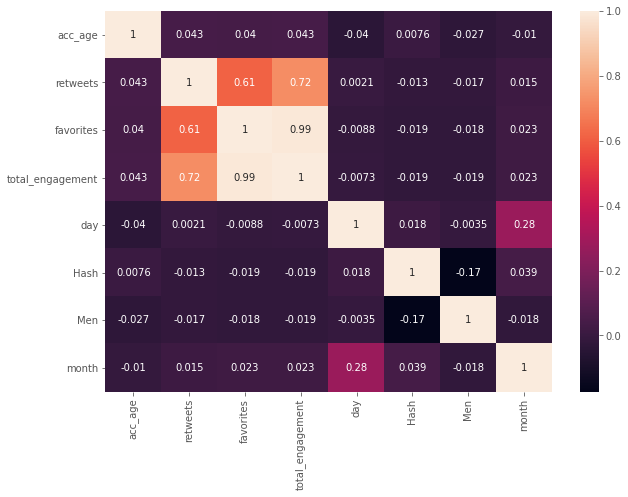

In [50]:
corr=df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True)

## length class

<AxesSubplot:xlabel='tweet_length', ylabel='count'>

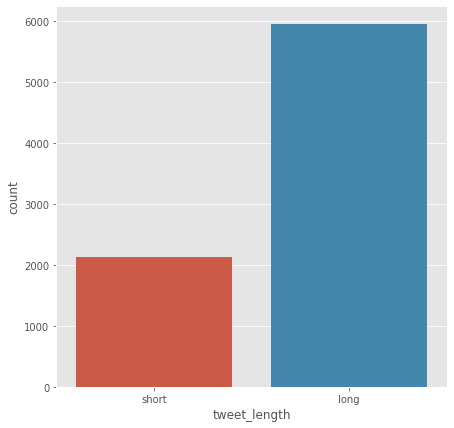

In [52]:
plt.figure(figsize=(7,7))
sns.countplot(x='tweet_length',data=df)

## Tweet Length / hashtags

<AxesSubplot:xlabel='Hash', ylabel='tweet_length'>

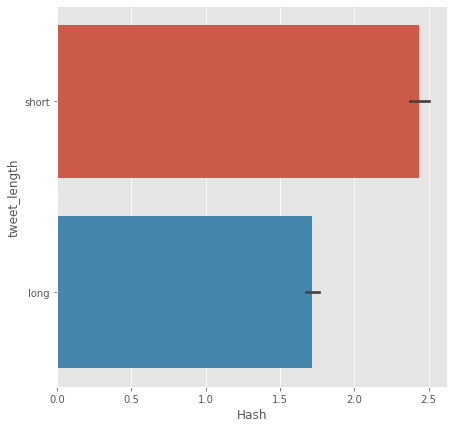

In [53]:
plt.figure(figsize=(7,7))
sns.barplot(x=df['Hash'],y=df['tweet_length'],data=df)

## tweet length / Mentions

<AxesSubplot:xlabel='tweet_length', ylabel='Men'>

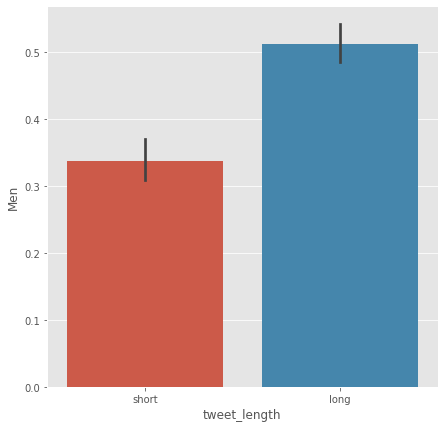

In [54]:
plt.figure(figsize=(7,7))
sns.barplot(x=df['tweet_length'],y=df['Men'],data=df)

## Verified Accounts

In [55]:
df['user_verified'].value_counts()

not_verified    7323
verified         759
Name: user_verified, dtype: int64

(-1.1505029161234455,
 1.0574951215706034,
 -1.2009314800414903,
 1.1048062907740432)

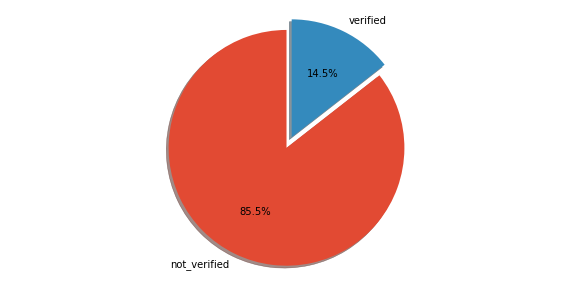

In [56]:
labels = 'not_verified', 'verified'
sizes = [1888, 319]
explode = (0.1, 0)  
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')

### only 14.5% tweets are verified

## Account Class

In [57]:
class_eng = df.groupby('acc_class',as_index=False).agg({'total_engagement':'sum',})

In [58]:
fig = px.bar(class_eng,
             x='acc_class',
             y='total_engagement',
             color='total_engagement',
             color_continuous_scale='Rainbow',
             title='Engagement By Account_Class')
fig.show()

## No media

In [60]:
Media = len(df[df['med']=='Media'])
No_Media = len(df[df['med']=='No Media'])
Platform = ['Media','No Media']
Count = [Media,No_Media]
#====
fig = px.pie(names = Platform,
             values = Count,
             title='Media/No Media',
            color_discrete_sequence = px.colors.sequential.Rainbow)
fig.update_traces(textposition='inside', textinfo='percent+label')

## Engagement with respect to date

In [61]:
line = df.groupby('date',as_index=False).agg({'total_engagement':'sum'})
fig = go.Figure()
fig.add_trace(go.Scatter(x=line.date, y=line.total_engagement,
                    mode='lines+markers'))

In [62]:
## days of december

In [63]:
december=df.loc[df['month']==12]
day_december = december.groupby('day',as_index=False).agg({'total_engagement':'sum'})

fig = px.scatter(day_december,
                 x='day',
                 y='total_engagement',
                 color_continuous_scale='Rainbow',
                 color='total_engagement',
                 size='total_engagement',
                 title='Most engaged days in December')
fig.show()

## Most of the engagements were from 12 to 14 December.

In [65]:
## Accounts per Engagements

In [66]:
ret = df.groupby('user_name',as_index=False).agg({'retweets':'sum'}).sort_values('retweets',ascending=False).head(10)
like = df.groupby('user_name',as_index=False).agg({'favorites':'sum'}).sort_values('favorites',ascending=False).head(10)
tot_eng = df.groupby('user_name',as_index=False).agg({'total_engagement':'sum'}).sort_values('total_engagement',ascending=False).head(10)


fig = px.bar(tot_eng,
             x='user_name',
             y='total_engagement',
             color='total_engagement',
             color_continuous_scale='Viridis',
             title='Accounts per Engagements')
fig.show()

## Account age per Engagement

In [67]:
age=df.groupby('acc_age',as_index=False).agg({'total_engagement':'sum'})
px.line(age,x='acc_age',y='total_engagement',labels={'x':'age','y':'engagement'})

In [14]:
df.head()

,name,location,description,created,followers,friends,favourites,verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
